In [1]:
### Importing libraries
import os
import numpy as np
import pandas as pd
from datetime import date
import datetime
from dateutil.parser import parse
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

print(os.getcwd())

import seaborn as sns  # visualisation
import matplotlib.pyplot as plt  # visualisation
%matplotlib inline

print("imported all required libraries")
pd.set_option('display.max_columns', 500)


/content
imported all required libraries


In [2]:
# Load the CSV file using pd.read_csv
df = pd.read_csv("KAG_conversion_data_raw.csv")
print("CSV file loaded")

CSV file loaded


In [3]:
# Display the shape of the DataFrame
print("Shape:", df.shape)

# Display the descriptive statistics
print("Descriptive statistics:")
print(df.describe())


Shape: (1143, 11)
Descriptive statistics:
              ad_id  xyz_campaign_id  fb_campaign_id     interest  \
count  1.143000e+03      1143.000000     1143.000000  1143.000000   
mean   9.872611e+05      1067.382327   133783.989501    32.766404   
std    1.939928e+05       121.629393    20500.308622    26.952131   
min    7.087460e+05       916.000000   103916.000000     2.000000   
25%    7.776325e+05       936.000000   115716.000000    16.000000   
50%    1.121185e+06      1178.000000   144549.000000    25.000000   
75%    1.121804e+06      1178.000000   144657.500000    31.000000   
max    1.314415e+06      1178.000000   179982.000000   114.000000   

        Impressions       Clicks        Spent  Total_Conversion  \
count  1.143000e+03  1143.000000  1143.000000       1143.000000   
mean   1.867321e+05    33.390201    51.360656          2.855643   
std    3.127622e+05    56.892438    86.908418          4.483593   
min    8.700000e+01     0.000000     0.000000          0.000000   
2

In [4]:
df.columns

Index(['ad_id', 'xyz_campaign_id', 'fb_campaign_id', 'age', 'gender',
       'interest', 'Impressions', 'Clicks', 'Spent', 'Total_Conversion',
       'Approved_Conversion'],
      dtype='object')

In [5]:
# 1) Overall missing cells in the dataframe
total_na = df.isna().sum().sum()
print(f"Total missing cells: {total_na}")

Total missing cells: 0


In [6]:
# Calculate row-level KPIs once
df['CTR'] = df['Clicks'] / df['Impressions'] * 100
df['ConversionRate'] = np.where(df['Clicks'] > 0,
                                df['Approved_Conversion'] / df['Clicks'] * 100,
                                0)
df['CPM'] = df['Spent'] / df['Impressions'] * 1000
df['CPC'] = np.where(df['Clicks'] > 0,
                     df['Spent'] / df['Clicks'],
                     np.nan)
df['CPA'] = np.where(df['Approved_Conversion'] > 0,
                     df['Spent'] / df['Approved_Conversion'],
                     np.nan)


In [8]:
# Check if 'Approved_Conversion' column exists and rename it to 'conversions'
if 'Approved_Conversion' in df.columns:
    df.rename(columns={'Approved_Conversion': 'conversions'}, inplace=True)

# --- Aggregations ---

# By age and gender
agg_demo = df.groupby(['age', 'gender']).agg(
    impressions=('Impressions', 'sum'),
    clicks=('Clicks', 'sum'),
    conversions=('conversions', 'sum'), # Use 'conversions'
    spent=('Spent', 'sum')
).reset_index()
agg_demo['CTR'] = agg_demo['clicks'] / agg_demo['impressions'] * 100
agg_demo['ConversionRate'] = np.where(agg_demo['clicks'] > 0,
                                agg_demo['conversions'] / agg_demo['clicks'] * 100, # Use 'conversions'
                                0)
agg_demo['CPM'] = agg_demo['spent'] / agg_demo['impressions'] * 1000
agg_demo['CPC'] = np.where(agg_demo['clicks'] > 0,
                     agg_demo['spent'] / agg_demo['clicks'],
                     np.nan)
agg_demo['CPA'] = np.where(agg_demo['conversions'] > 0,
                     agg_demo['spent'] / agg_demo['conversions'],
                     np.nan)

# By age only
agg_age = df.groupby('age').agg(
    impressions=('Impressions', 'sum'),
    clicks=('Clicks', 'sum'),
    conversions=('conversions', 'sum'), # Use 'conversions'
    spent=('Spent', 'sum')
).reset_index()
agg_age['CTR'] = agg_age['clicks'] / agg_age['impressions'] * 100
agg_age['ConversionRate'] = np.where(agg_age['clicks'] > 0,
                                agg_age['conversions'] / agg_age['clicks'] * 100,
                                0)
agg_age['CPM'] = agg_age['spent'] / agg_age['impressions'] * 1000
agg_age['CPC'] = np.where(agg_age['clicks'] > 0,
                     agg_age['spent'] / agg_age['clicks'],
                     np.nan)
agg_age['CPA'] = np.where(agg_age['conversions'] > 0,
                     agg_age['spent'] / agg_age['conversions'],
                     np.nan)

# By gender only
agg_gender = df.groupby('gender').agg(
    impressions=('Impressions', 'sum'),
    clicks=('Clicks', 'sum'),
    conversions=('conversions', 'sum'), # Use 'conversions'
    spent=('Spent', 'sum')
).reset_index()
agg_gender['ConversionRate'] = agg_gender['conversions'] / agg_gender['clicks'] * 100
agg_gender['CPA'] = agg_gender['spent'] / agg_gender['conversions']
agg_gender['CPM'] = agg_gender['spent'] / agg_gender['impressions'] * 1000

# --- Analysis summaries ---

# Sorted summaries
age_sorted_by_sales = agg_age.sort_values(by='conversions', ascending=False)
age_sorted_by_spend = agg_age.sort_values(by='spent', ascending=False)
gender_sorted_by_sales = agg_gender.sort_values(by='conversions', ascending=False)
gender_sorted_by_spend = agg_gender.sort_values(by='spent', ascending=False)

# Identify maxima for printing
max_sales_age = age_sorted_by_sales.iloc[0]
max_spend_age = age_sorted_by_spend.iloc[0]
max_sales_gender = gender_sorted_by_sales.iloc[0]
max_spend_gender = gender_sorted_by_spend.iloc[0]

# Display sorted summaries
print("Age groups ranked by approved conversions (descending):")
print(age_sorted_by_sales[['age', 'conversions', 'spent', 'ConversionRate', 'CPA']])
print("\nAge groups ranked by total spend (descending):")
print(age_sorted_by_spend[['age', 'spent', 'conversions', 'ConversionRate', 'CPA']])

print("\nGender groups ranked by approved conversions (descending):")
print(gender_sorted_by_sales[['gender', 'conversions', 'spent', 'ConversionRate', 'CPA']])
print("\nGender groups ranked by total spend (descending):")
print(gender_sorted_by_spend[['gender', 'spent', 'conversions', 'ConversionRate', 'CPA']])

# Print highest sales/spend for age and gender
print(f"\nHighest ad spend by age group: {max_spend_age['age']} "
      f"(spent {max_spend_age['spent']:.2f}, conversions {max_spend_age['conversions']}, "
      f"conversion rate {max_spend_age['ConversionRate']:.2f}%)")

print(f"Highest sales by age group: {max_sales_age['age']} "
      f"(conversions {max_sales_age['conversions']}, spent {max_sales_age['spent']:.2f}, "
      f"conversion rate {max_sales_age['ConversionRate']:.2f}%)")

print(f"\nHighest ad spend by gender: {max_spend_gender['gender']} "
      f"(spent {max_spend_gender['spent']:.2f}, conversions {max_spend_gender['conversions']}, "
      f"conversion rate {max_spend_gender['ConversionRate']:.2f}%)")

print(f"Highest sales by gender: {max_sales_gender['gender']} "
      f"(conversions {max_sales_gender['conversions']}, spent {max_sales_gender['spent']:.2f}, "
      f"conversion rate {max_sales_gender['ConversionRate']:.2f}%)")

Age groups ranked by approved conversions (descending):
     age  conversions         spent  ConversionRate        CPA
0  30-34          494  15252.399986        5.209322  30.875304
3  45-49          208  20750.669997        1.501588  99.762837
1  35-39          207  11112.429994        2.917959  53.683237
2  40-44          170  11589.729981        2.197518  68.174882

Age groups ranked by total spend (descending):
     age         spent  conversions  ConversionRate        CPA
3  45-49  20750.669997          208        1.501588  99.762837
0  30-34  15252.399986          494        5.209322  30.875304
2  40-44  11589.729981          170        2.197518  68.174882
1  35-39  11112.429994          207        2.917959  53.683237

Gender groups ranked by approved conversions (descending):
  gender  conversions         spent  ConversionRate        CPA
1      M          584  24202.609995        4.087632  41.442825
0      F          495  34502.619963        2.073038  69.702263

Gender groups ra

In [9]:
# Optional: keep age in natural order
age_order = ['30-34','35-39','40-44','45-49']
agg_demo['age'] = pd.Categorical(agg_demo['age'], categories=age_order, ordered=True)

# Pivots
sales_pivot = agg_demo.pivot(index='age', columns='gender', values='conversions').sort_index()
spend_pivot = agg_demo.pivot(index='age', columns='gender', values='spent').sort_index()

# Print nicely
print("\nAd Sales (Approved Conversions) pivot — rows: age, cols: gender")
print(sales_pivot.to_string(
    index=True,
    formatters={col: (lambda v: f"{int(v)}" if pd.notna(v) else "NA") for col in sales_pivot.columns}
))

print("\nAd Spends pivot — rows: age, cols: gender")
print(spend_pivot.to_string(
    index=True,
    formatters={col: (lambda v: f"{v:.2f}" if pd.notna(v) else "NA") for col in spend_pivot.columns}
))

# (Optional) save to CSV
# sales_pivot.to_csv('pivot_ad_sales.csv')
# spend_pivot.to_csv('pivot_ad_spends.csv')



Ad Sales (Approved Conversions) pivot — rows: age, cols: gender
gender   F   M
age           
30-34  195 299
35-39   95 112
40-44   93  77
45-49  112  96

Ad Spends pivot — rows: age, cols: gender
gender        F       M
age                    
30-34   7611.48 7640.92
35-39   6061.35 5051.08
40-44   7396.58 4193.15
45-49  13433.21 7317.46


On futher examination, it shows, that the Ad  and the conversion rate is the most for 30-34 age group, and the Males in this age group have higher approved conversions than females

Overall, highest ad spend is done by females, when not considering any age group

On the other hand, the highest Sales spend and CPA is found  in femnales with 45-49 age group and so is the CPA. The females in this group have a higher ad spend.

Overall, the best category for Ad sales in Males in 30-35 age group. Overall, males contribute to ighest Ad Sales.

In [10]:
# agg_demo with: impressions, clicks, conversions, spent, ConversionRate

# Spend-based efficiency metrics
agg_demo['CPA'] = np.where(agg_demo['conversions'] > 0,
                           agg_demo['spent'] / agg_demo['conversions'], np.nan)
agg_demo['Conv_per_1k_Spend'] = np.where(agg_demo['spent'] > 0,
                                         agg_demo['conversions'] / agg_demo['spent'] * 1000, np.nan)

# 1) SALES VIEW: Conversions + Conversion Rate (clicks -> sales effectiveness)
sales_pivot = (agg_demo
               .pivot_table(index='age', columns='gender',
                            values=['conversions','ConversionRate'],
                            aggfunc='first')
               .sort_index())

print("\nSales pivot (Conversions + Conversion Rate %)")
print(sales_pivot.to_string(formatters={
    ('conversions','F'): lambda v: f"{int(v)}",
    ('conversions','M'): lambda v: f"{int(v)}",
    ('ConversionRate','F'): lambda v: f"{v:.2f}",
    ('ConversionRate','M'): lambda v: f"{v:.2f}",
}))

# 2) SPEND VIEW: Spend + CPA + Conversions per ₹1,000 spend (spend -> sales efficiency)
spend_pivot = (agg_demo
               .pivot_table(index='age', columns='gender',
                            values=['spent','CPA','Conv_per_1k_Spend'],
                            aggfunc='first')
               .sort_index())

fmt = {}
for col in spend_pivot.columns:
    met, _ = col
    fmt[col] = (lambda v: f"{v:.2f}") if met in ('spent','CPA') else (lambda v: f"{v:.3f}")

print("\nSpend pivot (Spend + CPA + Conversions per ₹1,000 Spend)")
print(spend_pivot.to_string(formatters=fmt))



Sales pivot (Conversions + Conversion Rate %)
       ConversionRate      conversions    
gender              F    M           F   M
age                                       
30-34            3.82 6.82         195 299
35-39            2.28 3.82          95 112
40-44            1.80 3.01          93  77
45-49            1.19 2.18         112  96

Spend pivot (Spend + CPA + Conversions per ₹1,000 Spend)
          CPA       Conv_per_1k_Spend           spent        
gender      F     M                 F      M        F       M
age                                                          
30-34   39.03 25.55            25.619 39.131  7611.48 7640.92
35-39   63.80 45.10            15.673 22.173  6061.35 5051.08
40-44   79.53 54.46            12.573 18.363  7396.58 4193.15
45-49  119.94 76.22             8.338 13.119 13433.21 7317.46


Sales pivot → funnel quality (clicks → sales)

Best funnel: Males with 30–34 age group with CVR 6.82% and 299 conversions. Next best is Female with 30–34 age group (CVR 3.82%, 195 conversions). Younger cohorts turn clicks into purchases most reliably.

Clear age decay: Conversion rate falls steadily with age for both genders (e.g., Males: 6.82 → 2.18%, Females: 3.82 → 1.19% from 30–34 to 45–49). Older users click, but far fewer finish the purchase.

Gender gap at every age: Men convert ~1.7–2.1× better than women of the same age (e.g., at 35–39: 3.82% vs 2.28%).

What it means: If one only looked at the funnel quality, one would  prioritise M 30–34, then F 30–34, and deprioritise 45–49 for both genders.

Spend pivot → budget efficiency (money → sales)

CPA (₹/sale): Lowest in Males with age group 30–34 (₹25.55), highest in F 45–49 (₹119.94).

Overall, for both genders, the CPA begins to rise with the increase in age group

Conversions per ₹1,000 spend (Conv_per_1k_Spend = 1000 / CPA):

Males for age group 30–34: 39.131 (best)

Females for age group  45–49: 8.338 (worst)

The age group 30-34 has the highest Conversions per ₹1,000 spend for both genders.

SPENDS:

Spend actually deployed (₹): Big outlay on females in age group 45–49 (₹13,433) despite the weakest efficiency; similar spend on Males with age group 30–34 (₹7,641) yields far more sales per rupee.

Actionables:

Scale the winners:

Males in 30–34 age group should be first  priority (best Conversion rate and CPA).

Then Female for age group 30–34 and Males in age group 35–39 while watching marginal CPA as one raises budgets.They generate the most sales per impression.

Trim or fix

Females in age group 45–49 (and, secondarily, Females in age group  40–44): reduce bids/budget unless there’s superior LTV. If one must keep reach, move to retargeting, tighten audience filters, and test new creative/landing pages.


Optimise to CPA / Conv_per_1k_Spend, not CTR.

Set target-CPA/bid caps per segment; monitor marginal CPA weekly to catch saturation.

If volume is a constraint, expand laterally (e.g., Males in age group 35–39) before moving into costly segments.

Bottom line: Younger male cohorts—especially Males in age group 30–34—deliver the strongest funnel and the best rupee efficiency. Rebalance budget toward them and away from older female cohorts until efficiency improves.






CTR & CONVERSION RATE BY AGE GROUP + GENDER|| CPM AND CPA BY AGE GROUP +GENDER


In [11]:
# --- Aggregate by AGE ---
agg_age = df.groupby('age').agg(
    impressions=('Impressions', 'sum'),
    clicks=('Clicks', 'sum'),
    conversions=('conversions', 'sum'), # Use 'conversions'
    spent=('Spent', 'sum')
).reset_index()

# Compute metrics on age-level data
agg_age['CTR'] = agg_age['clicks'] / agg_age['impressions'] * 100
agg_age['ConversionRate'] = np.where(
    agg_age['clicks'] > 0,
    agg_age['conversions'] / agg_age['clicks'] * 100,
    0
)
agg_age['CPA'] = np.where(
    agg_age['conversions'] > 0,
    agg_age['spent'] / agg_age['conversions'],
    np.nan
)
agg_age['CPM'] = agg_age['spent'] / agg_age['impressions'] * 1000

# --- Aggregate by GENDER ---
agg_gender = df.groupby('gender').agg(
    impressions=('Impressions', 'sum'),
    clicks=('Clicks', 'sum'),
    conversions=('conversions', 'sum'), # Use 'conversions'
    spent=('Spent', 'sum')
).reset_index()

# Compute metrics on gender-level data
agg_gender['CTR'] = agg_gender['clicks'] / agg_gender['impressions'] * 100
agg_gender['ConversionRate'] = np.where(
    agg_gender['clicks'] > 0,
    agg_gender['conversions'] / agg_gender['clicks'] * 100,
    0
)
agg_gender['CPA'] = np.where(
    agg_gender['conversions'] > 0,
    agg_gender['spent'] / agg_gender['conversions'],
    np.nan
)
agg_gender['CPM'] = agg_gender['spent'] / agg_gender['impressions'] * 1000

# 2. Display CTR and conversion rate by AGE and by GENDER
print("CTR and Conversion Rate by Age:")
print(agg_age[['age', 'CTR', 'ConversionRate']])

print("\nCTR and Conversion Rate by Gender:")
print(agg_gender[['gender', 'CTR', 'ConversionRate']])

# 3. Differences in CPA and CPM between age segments
print("\nCPA and CPM by Age:")
print(agg_age[['age', 'CPA', 'CPM']])

# Find and print lowest/highest CPA and CPM among age groups
min_cpa_age = agg_age.loc[agg_age['CPA'].idxmin()]
max_cpa_age = agg_age.loc[agg_age['CPA'].idxmax()]
min_cpm_age = agg_age.loc[agg_age['CPM'].idxmin()]
max_cpm_age = agg_age.loc[agg_age['CPM'].idxmax()]

print(f"\nLowest CPA by age: {min_cpa_age['age']} (CPA = {min_cpa_age['CPA']:.2f})")
print(f"Highest CPA by age: {max_cpa_age['age']} (CPA = {max_cpa_age['CPA']:.2f})")
print(f"Lowest CPM by age: {min_cpm_age['age']} (CPM = {min_cpm_age['CPM']:.4f})")
print(f"Highest CPM by age: {max_cpm_age['age']} (CPM = {max_cpm_age['CPM']:.4f})")

# 4. Differences in CPA and CPM between gender segments
print("\nCPA and CPM by Gender:")
print(agg_gender[['gender', 'CPA', 'CPM']])

# Find and print lowest/highest CPA and CPM among genders
min_cpa_gender = agg_gender.loc[agg_gender['CPA'].idxmin()]
max_cpa_gender = agg_gender.loc[agg_gender['CPA'].idxmax()]
min_cpm_gender = agg_gender.loc[agg_gender['CPM'].idxmin()]
max_cpm_gender = agg_gender.loc[agg_gender['CPM'].idxmax()]

print(f"\nLowest CPA by gender: {min_cpa_gender['gender']} (CPA = {min_cpa_gender['CPA']:.2f})")
print(f"Highest CPA by gender: {max_cpa_gender['gender']} (CPA = {max_cpa_gender['CPA']:.2f})")
print(f"Lowest CPM by gender: {min_cpm_gender['gender']} (CPM = {min_cpm_gender['CPM']:.4f})")
print(f"Highest CPM by gender: {max_cpm_gender['gender']} (CPM = {max_cpm_gender['CPM']:.4f})")

CTR and Conversion Rate by Age:
     age       CTR  ConversionRate
0  30-34  0.013947        5.209322
1  35-39  0.016848        2.917959
2  40-44  0.019533        2.197518
3  45-49  0.021734        1.501588

CTR and Conversion Rate by Gender:
  gender       CTR  ConversionRate
0      F  0.020788        2.073038
1      M  0.014494        4.087632

CPA and CPM by Age:
     age        CPA       CPM
0  30-34  30.875304  0.224323
1  35-39  53.683237  0.263924
2  40-44  68.174882  0.292638
3  45-49  99.762837  0.325588

Lowest CPA by age: 30-34 (CPA = 30.88)
Highest CPA by age: 45-49 (CPA = 99.76)
Lowest CPM by age: 30-34 (CPM = 0.2243)
Highest CPM by age: 45-49 (CPM = 0.3256)

CPA and CPM by Gender:
  gender        CPA       CPM
0      F  69.702263  0.300381
1      M  41.442825  0.245532

Lowest CPA by gender: M (CPA = 41.44)
Highest CPA by gender: F (CPA = 69.70)
Lowest CPM by gender: M (CPM = 0.2455)
Highest CPM by gender: F (CPM = 0.3004)


Yes—there are large, consistent differences in both CPA and CPM by age and gender, and they have clear budget implications.

What the data shows **bold text**

For all age groups:

CPA rises from ₹30.88 (30–34) → ₹99.76 (45–49), ~3.2× higher.

CPM rises from ₹0.2243 → ₹0.3256, ~45% higher.

For all genders, irrespective of age groups, Male CPA is 41.44 vs Female CPA is 69.70 → females are costlier per sale.

The lowest Male CPM = ₹0.2455 vs Female CPM = ₹0.3004 → females are costlier
per 1,000 impressions.

In [12]:
import pandas as pd
import numpy as np

# ---- Aggregate first (correct way to compute rates) ----
ctr_cvr = (df.groupby(['age', 'gender'], as_index=False)
             .agg(impressions=('Impressions', 'sum'),
                  clicks=('Clicks', 'sum'),
                  conversions=('conversions', 'sum'))) # Use 'conversions'

# Compute CTR and Conversion Rate on aggregated totals
ctr_cvr['CTR'] = ctr_cvr['clicks'] / ctr_cvr['impressions'] * 100
ctr_cvr['ConversionRate'] = np.where(
    ctr_cvr['clicks'] > 0,
    ctr_cvr['conversions'] / ctr_cvr['clicks'] * 100,
    np.nan
)

# Optional: keep age rows in natural order
age_order = ['30-34','35-39','40-44','45-49']
ctr_cvr['age'] = pd.Categorical(ctr_cvr['age'], categories=age_order, ordered=True)

# ---- Pivots: rows = age group, columns = gender ----
ctr_pivot  = ctr_cvr.pivot(index='age', columns='gender', values='CTR').reindex(age_order)
cvr_pivot  = ctr_cvr.pivot(index='age', columns='gender', values='ConversionRate').reindex(age_order)

print("\nCTR by age group and gender) — %")
print(ctr_pivot.to_string(formatters={col: (lambda v: f"{v:.4f}") for col in ctr_pivot.columns}))

print("\nConversion Rate by age group and gender) — %")
print(cvr_pivot.to_string(formatters={col: (lambda v: f"{v:.2f}") for col in cvr_pivot.columns}))


CTR by age group and gender) — %
gender      F      M
age                 
30-34  0.0162 0.0120
35-39  0.0194 0.0142
40-44  0.0221 0.0158
45-49  0.0246 0.0175

Conversion Rate by age group and gender) — %
gender    F    M
age             
30-34  3.82 6.82
35-39  2.28 3.82
40-44  1.80 3.01
45-49  1.19 2.18


Age group 30-35 has the highest CTR and conversion rate. Howver, whe we split them further into male and female for this age group, the females have a slightly better CTR than males and a lower conversion rate than males.
However, when we compare the overall gender for all age groups, females have a higher CTR than males but a lower conversion rate than males.

GRANULAR LEVEL ANALYHSIS (XYZ CAMPAIGN ID by FB_CAMPAIGN ID & AD_ID

In [13]:
import pandas as pd
import numpy as np

# --- Clean & ensure grouping keys are consistent ---
df['age'] = df['age'].astype(str).str.strip()
df['gender'] = df['gender'].astype(str).str.strip().str.upper()

# --- Aggregate by GENDER + AGE (one row per segment) ---
agg_demo = (df.groupby(['gender', 'age'], as_index=False)
              .agg(impressions=('Impressions', 'sum'),
                   conversions=('conversions', 'sum'), # Use 'conversions'
                   spent=('Spent', 'sum')))

# Compute CPA & CPM on aggregated data (avoid /0)
agg_demo['CPA'] = np.where(agg_demo['conversions'] > 0,
                           agg_demo['spent'] / agg_demo['conversions'],
                           np.nan)
agg_demo['CPM'] = np.where(agg_demo['impressions'] > 0,
                           agg_demo['spent'] / agg_demo['impressions'] * 1000,
                           np.nan)

# Keep ONLY the four requested columns and sort for readability
grouped_view = (agg_demo[['gender', 'age', 'CPA', 'CPM']]
                .sort_values(['age', 'gender'])
                .reset_index(drop=True))


# OPTIONAL: Pivot tables (nice grouped display, not individual records)
cpa_pivot = grouped_view.pivot(index='age', columns='gender', values='CPA')
cpm_pivot = grouped_view.pivot(index='age', columns='gender', values='CPM')

print("\nCPA pivot (rows: age, cols: gender):")
print(cpa_pivot.to_string(formatters={col: (lambda v: f"{v:.2f}") for col in cpa_pivot.columns}))

print("\nCPM pivot (rows: age, cols: gender):")
print(cpm_pivot.to_string(formatters={col: (lambda v: f"{v:.4f}") for col in cpm_pivot.columns}))


CPA pivot (rows: age, cols: gender):
gender      F     M
age                
30-34   39.03 25.55
35-39   63.80 45.10
40-44   79.53 54.46
45-49  119.94 76.22

CPM pivot (rows: age, cols: gender):
gender      F      M
age                 
30-34  0.2411 0.2098
35-39  0.2827 0.2444
40-44  0.3161 0.2587
45-49  0.3493 0.2895


CPA ANDF CPM BY SEX*AGE GROUP

Intersection (age × gender)

Best (cheapest): Male for age group 30–34 → CPA ₹25.55  and CPM ₹0.2098.

Worst (costliest): Female for age group 45–49 → CPA ₹119.94, CPM ₹0.3493.

Gap: CPA is ~4.7× higher and CPM ~1.66× higher in the worst segment vs. the best.

Spend-to-sales efficiency (conversions per ₹1,000 spend = 1000/CPA)


The female segment for age group 45–49 ≈ 8.34 (weakest).

What this means for budget optimisation

Scale winners (low CPA + low CPM):



These segments deliver more conversions per rupee and cheaper reach.

Trim or rethink high-cost segments:

Female 45–49 and Female 40–44 are the least efficient (high CPA and CPM).

If they must stay for strategic reasons, move spend to retargeting, tighten audiences, and test new creatives/offers/landing pages with bid/target-CPA caps.

Don’t chase CTR alone:

Earlier results showed CTR increases with age, but conversion rate falls—so older cohorts look active but don’t buy efficiently. Optimise to CPA / conversions per ₹1k spend, not clicks.

Allocate by efficiency (data-only rule of thumb):

Monitor marginal CPA as you scale the best segments to avoid saturation; re-balance weekly and adjust bid caps to keep CPM drift

What this means for budget

Scale where it’s cheapest and converts best:
Prioritize Men 30–34 (then Men 35–39, Women 30–34 for additional reach).

De-prioritize costly segments:
Reduce bids/budgets for Women 45–49 (and older cohorts generally) unless there’s proven LTV/strategic value.


In [14]:
# ---------- Clean / standardize ----------
df['xyz_campaign_id'] = df['xyz_campaign_id'].astype(str).str.strip()
# keep column names consistent
df.rename(columns={'Approved_Conversion': 'conversions'}, inplace=True)

# ---------- Aggregate at CAMPAIGN level ----------
agg_camp = (df.groupby('xyz_campaign_id', as_index=False)
              .agg(impressions=('Impressions','sum'),
                   clicks=('Clicks','sum'),
                   conversions=('conversions','sum')))

# Metrics (computed on aggregated totals; safe divisions)
agg_camp['CTR'] = np.where(agg_camp['impressions'] > 0,
                           agg_camp['clicks'] / agg_camp['impressions'] * 100, np.nan)
agg_camp['ConversionRate'] = np.where(agg_camp['clicks'] > 0,
                                      agg_camp['conversions'] / agg_camp['clicks'] * 100, np.nan)

# Optional overall funnel efficiency: conversions per 1,000 impressions
# (how many sales per 1k impressions = CTR% * CVR% / 10)
agg_camp['Conv_per_1k_Impr'] = (agg_camp['CTR'] * agg_camp['ConversionRate']) / 10

# ---------- Pivots (campaign rows) ----------
ctr_pivot = (agg_camp
             .pivot_table(index='xyz_campaign_id', values='CTR', aggfunc='first')
             .sort_values('CTR', ascending=False))

cvr_pivot = (agg_camp
             .pivot_table(index='xyz_campaign_id', values='ConversionRate', aggfunc='first')
             .sort_values('ConversionRate', ascending=False))

both_pivot = (agg_camp
              .pivot_table(index='xyz_campaign_id',
                           values=['CTR','ConversionRate','Conv_per_1k_Impr'],
                           aggfunc='first')
              .sort_values(('Conv_per_1k_Impr'), ascending=False))

# ---------- Nice printing ----------
print("\nCTR by campaign (%), highest to lowest:")
print(ctr_pivot.to_string(formatters={'CTR': lambda v: f"{v:.4f}" if pd.notna(v) else "NA"}))

print("\nConversion Rate by campaign (%), highest to lowest:")
print(cvr_pivot.to_string(formatters={'ConversionRate': lambda v: f"{v:.2f}" if pd.notna(v) else "NA"}))

print("\nOverall funnel efficiency (per campaign): CTR %, Conversion Rate %, Conversions per 1k Impressions")
print(both_pivot.to_string(formatters={
    ('CTR',):              lambda v: f"{v:.4f}" if pd.notna(v) else "NA",
    ('ConversionRate',):   lambda v: f"{v:.2f}"  if pd.notna(v) else "NA",
    ('Conv_per_1k_Impr',): lambda v: f"{v:.3f}" if pd.notna(v) else "NA",
}))

# ---------- Direct answer: best/worst campaigns ----------
best_ctr = agg_camp.loc[agg_camp['CTR'].idxmax()]
worst_ctr = agg_camp.loc[agg_camp['CTR'].idxmin()]
best_cvr = agg_camp.loc[agg_camp['ConversionRate'].idxmax()]
worst_cvr = agg_camp.loc[agg_camp['ConversionRate'].idxmin()]
best_overall = agg_camp.loc[agg_camp['Conv_per_1k_Impr'].idxmax()]
worst_overall = agg_camp.loc[agg_camp['Conv_per_1k_Impr'].idxmin()]

print(f"\nHIGHEST CTR (impressions → clicks): campaign {best_ctr['xyz_campaign_id']} "
      f"CTR = {best_ctr['CTR']:.4f}%")

print(f"LOWEST  CTR: campaign {worst_ctr['xyz_campaign_id']} "
      f"CTR = {worst_ctr['CTR']:.4f}%")

print(f"\nHIGHEST Conversion Rate (clicks → sales): campaign {best_cvr['xyz_campaign_id']} "
      f"CVR = {best_cvr['ConversionRate']:.2f}%")

print(f"LOWEST  Conversion Rate: campaign {worst_cvr['xyz_campaign_id']} "
      f"CVR = {worst_cvr['ConversionRate']:.2f}%")

print(f"\nBEST end-to-end (sales per 1,000 impressions): campaign {best_overall['xyz_campaign_id']} "
      f"= {best_overall['Conv_per_1k_Impr']:.3f}")

print(f"WORST end-to-end (sales per 1,000 impressions): campaign {worst_overall['xyz_campaign_id']} "
      f"= {worst_overall['Conv_per_1k_Impr']:.3f}")


CTR by campaign (%), highest to lowest:
                   CTR
xyz_campaign_id       
936             0.0244
916             0.0234
1178            0.0176

Conversion Rate by campaign (%), highest to lowest:
                ConversionRate
xyz_campaign_id               
916                      21.24
936                       9.22
1178                      2.42

Overall funnel efficiency (per campaign): CTR %, Conversion Rate %, Conversions per 1k Impressions
                      CTR  Conv_per_1k_Impr  ConversionRate
xyz_campaign_id                                            
916              0.023399          0.049697       21.238938
936              0.024409          0.022514        9.223790
1178             0.017609          0.004257        2.417656

HIGHEST CTR (impressions → clicks): campaign 936 CTR = 0.0244%
LOWEST  CTR: campaign 1178 CTR = 0.0176%

HIGHEST Conversion Rate (clicks → sales): campaign 916 CVR = 21.24%
LOWEST  Conversion Rate: campaign 1178 CVR = 2.42%

BEST end-t

The campaign is most effective where both CTR and Conversion Rate are high; those same campaigns will top the Conv_per_1k_Impr pivot.

Camopaign id 916 seems to be performing the best

In [15]:
# ---------- Ensure/normalize IDs ----------
if 'fb_campaign_id' not in df.columns:
    guess = next((c for c in df.columns
                  if c.lower().replace(' ', '_') in ('fb_campaign_id','fbcampaignid')), None)
    if guess:
        df = df.rename(columns={guess: 'fb_campaign_id'})

df['fb_campaign_id']  = df['fb_campaign_id'].astype(str).str.strip()
df['xyz_campaign_id'] = df['xyz_campaign_id'].astype(str).str.strip()

# ---------- Aggregate at FB CAMPAIGN level ----------
agg_fb = (df.groupby('fb_campaign_id', as_index=False)
            .agg(impressions=('Impressions','sum'),
                 clicks=('Clicks','sum'),
                 conversions=('conversions','sum')))

# Metrics on aggregated totals
agg_fb['CTR'] = np.where(agg_fb['impressions'] > 0,
                         agg_fb['clicks'] / agg_fb['impressions'] * 100, np.nan)
agg_fb['ConversionRate'] = np.where(agg_fb['clicks'] > 0,
                                    agg_fb['conversions'] / agg_fb['clicks'] * 100, np.nan)
agg_fb['Conv_per_1k_Impr'] = (agg_fb['CTR'] * agg_fb['ConversionRate']) / 10.0

# ---------- Attach representative xyz_campaign_id per fb_campaign_id ----------
pair_rank = (df.groupby(['fb_campaign_id','xyz_campaign_id'], as_index=False)
               .agg(impressions=('Impressions','sum'),
                    clicks=('Clicks','sum'),
                    conversions=('conversions','sum'),
                    spent=('Spent','sum')))
# choose xyz per FB campaign by conversions DESC, then spent, clicks, impressions
top_xyz_per_fb = (pair_rank
                  .sort_values(['fb_campaign_id','conversions','spent','clicks','impressions'],
                               ascending=[True, False, False, False, False])
                  .drop_duplicates(subset=['fb_campaign_id']))
agg_fb = agg_fb.merge(top_xyz_per_fb[['fb_campaign_id','xyz_campaign_id']],
                      on='fb_campaign_id', how='left')

# ---------- Helpers: show top-5 asc/desc with xyz_campaign_id ----------
def _show_top5_with_xyz(tbl, metric, label, fmt="{:.4f}"):
    cols = ['fb_campaign_id','xyz_campaign_id', metric]
    asc5  = tbl[cols].sort_values(metric, ascending=True).head(5)
    desc5 = tbl[cols].sort_values(metric, ascending=False).head(5)
    print(f"\n[FB] TOP 5 {label} ↑ (ascending)")
    print(asc5.to_string(index=False, formatters={
        metric: (lambda v: "NA" if pd.isna(v) else fmt.format(v))
    }))
    print(f"\n[FB] TOP 5 {label} ↓ (descending)")
    print(desc5.to_string(index=False, formatters={
        metric: (lambda v: "NA" if pd.isna(v) else fmt.format(v))
    }))

_show_top5_with_xyz(agg_fb, 'CTR',              'CTR (%)',                        fmt="{:.4f}")
_show_top5_with_xyz(agg_fb, 'ConversionRate',   'Conversion Rate (%)',            fmt="{:.2f}")
_show_top5_with_xyz(agg_fb, 'Conv_per_1k_Impr', 'Conversions per 1k Impressions', fmt="{:.3f}")



[FB] TOP 5 CTR (%) ↑ (ascending)
fb_campaign_id xyz_campaign_id    CTR
        123562             936 0.0000
        123567             936 0.0000
        123588             936 0.0000
        123597             936 0.0000
        123639             936 0.0000

[FB] TOP 5 CTR (%) ↓ (descending)
fb_campaign_id xyz_campaign_id    CTR
        109857             936 0.1059
        123464             936 0.0845
        123723             936 0.0610
        123627             936 0.0565
        123516             936 0.0531

[FB] TOP 5 Conversion Rate (%) ↑ (ascending)
fb_campaign_id xyz_campaign_id ConversionRate
        179974            1178           0.00
        103917             916           0.00
        179971            1178           0.00
        103940             916           0.00
        179979            1178           0.00

[FB] TOP 5 Conversion Rate (%) ↓ (descending)
fb_campaign_id xyz_campaign_id ConversionRate
        123440             936         150.00
        104396

In [16]:
import pandas as pd
import numpy as np

# (Optional) keep IDs tidy
df['xyz_campaign_id'] = df['xyz_campaign_id'].astype(str).str.strip()
df['ad_id'] = df['ad_id'].astype(str).str.strip()

# Aggregate by age and gender, include a single ad_id and xyz_campaign_id (representatives)
agg_demo = df.groupby(['age', 'gender']).agg(
    ad_id=('ad_id', 'first'),                     # representative ad_id per segment
    xyz_campaign_id=('xyz_campaign_id', 'first'), # representative xyz_campaign_id per segment
    impressions=('Impressions', 'sum'),
    clicks=('Clicks', 'sum'),
    conversions=('conversions', 'sum'),           # already renamed earlier
    spent=('Spent', 'sum')
).reset_index()

# Compute aggregated metrics (same as before)
agg_demo['CTR'] = agg_demo['clicks'] / agg_demo['impressions'] * 100
agg_demo['ConversionRate'] = agg_demo['conversions'] / agg_demo['clicks'] * 100
agg_demo['CPA'] = agg_demo['spent'] / agg_demo['conversions']
agg_demo['CPM'] = agg_demo['spent'] / agg_demo['impressions'] * 1000



# Identify segments with the lowest and highest CPA
lowest_cpa = agg_demo.sort_values(by='CPA').head(3)
highest_cpa = agg_demo.sort_values(by='CPA', ascending=False).head(3)
print("\nSegments (with representative IDs) with the lowest CPA:")
print(lowest_cpa[['age', 'gender', 'ad_id', 'xyz_campaign_id', 'CPA']])

print("\nSegments (with representative IDs) with the highest CPA:")
print(highest_cpa[['age', 'gender', 'ad_id', 'xyz_campaign_id', 'CPA']])

# Identify segments with the lowest and highest CPM
lowest_cpm = agg_demo.sort_values(by='CPM').head(3)
highest_cpm = agg_demo.sort_values(by='CPM', ascending=False).head(3)
print("\nSegments (with representative IDs) with the lowest CPM:")
print(lowest_cpm[['age', 'gender', 'ad_id', 'xyz_campaign_id', 'CPM']])

print("\nSegments (with representative IDs) with the highest CPM:")
print(highest_cpm[['age', 'gender', 'ad_id', 'xyz_campaign_id', 'CPM']])



Segments (with representative IDs) with the lowest CPA:
     age gender   ad_id xyz_campaign_id        CPA
1  30-34      M  708746             916  25.554916
0  30-34      F  710477             916  39.033231
3  35-39      M  709179             916  45.098929

Segments (with representative IDs) with the highest CPA:
     age gender   ad_id xyz_campaign_id         CPA
6  45-49      F  711764             916  119.939375
4  40-44      F  711623             916   79.533118
7  45-49      M  710045             916   76.223542

Segments (with representative IDs) with the lowest CPM:
     age gender   ad_id xyz_campaign_id       CPM
1  30-34      M  708746             916  0.209792
0  30-34      F  710477             916  0.241086
3  35-39      M  709179             916  0.244425

Segments (with representative IDs) with the highest CPM:
     age gender   ad_id xyz_campaign_id       CPM
6  45-49      F  711764             916  0.349317
4  40-44      F  711623             916  0.316145
7  45-49

AD ID - 708746 has the lowest CPA and CPM. AD ID 711764 has the highest CPA and the highest CPM.  They all belong to XYZ campaign id 936.

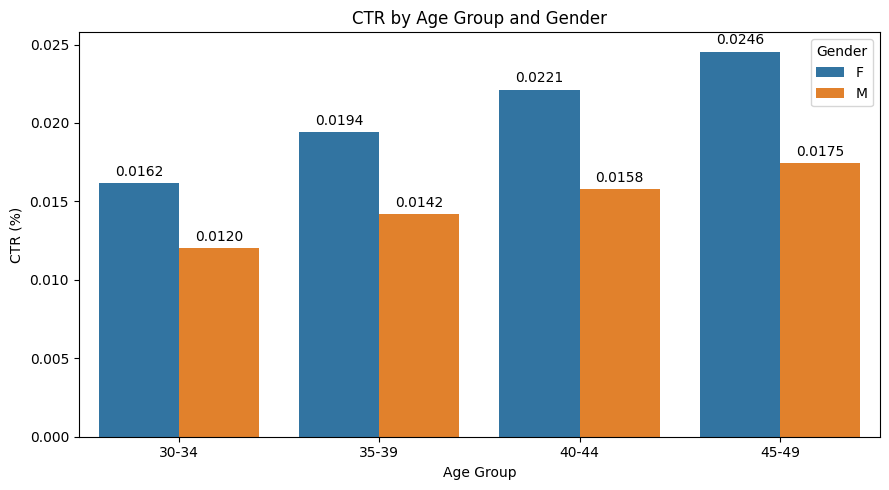

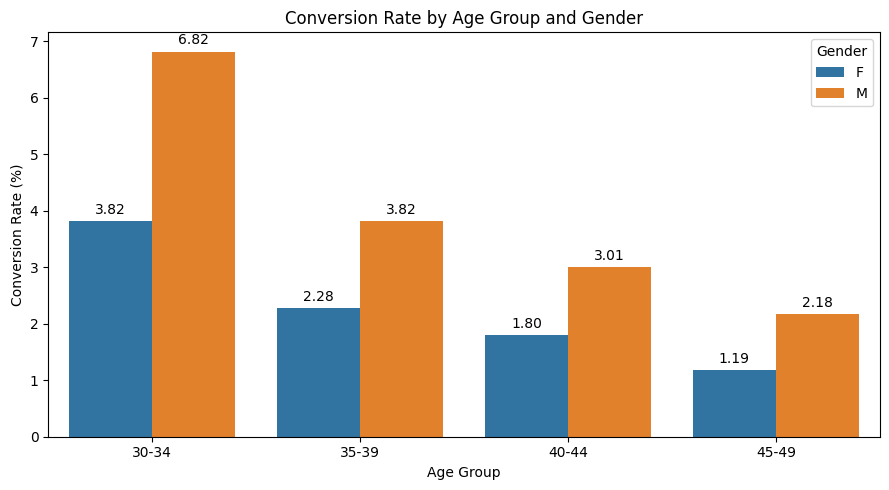

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure display order
age_order = ['30-34','35-39','40-44','45-49']
gender_order = ['F','M']

# ----- CTR bar chart (hue = gender) -----
plt.figure(figsize=(9, 5))
ax = sns.barplot(
    data=ctr_cvr, x='age', y='CTR', hue='gender',
    order=age_order, hue_order=gender_order, errorbar=None
)
ax.set_title('CTR by Age Group and Gender')
ax.set_xlabel('Age Group'); ax.set_ylabel('CTR (%)')
ax.legend(title='Gender')

# add labels
for c in ax.containers:
    ax.bar_label(c, labels=[f"{h:.4f}" for h in c.datavalues], padding=3)
plt.tight_layout()
plt.show()

# ----- Conversion Rate bar chart (hue = gender) -----
plt.figure(figsize=(9, 5))
ax = sns.barplot(
    data=ctr_cvr, x='age', y='ConversionRate', hue='gender',
    order=age_order, hue_order=gender_order, errorbar=None
)
ax.set_title('Conversion Rate by Age Group and Gender')
ax.set_xlabel('Age Group'); ax.set_ylabel('Conversion Rate (%)')
ax.legend(title='Gender')

# add labels
for c in ax.containers:
    ax.bar_label(c, labels=[f"{h:.2f}" for h in c.datavalues], padding=3)
plt.tight_layout()
plt.show()


Costs rise with age and are consistently higher for women than men. That has clear budget implications.

What the numbers say (from the pivots)

Lowest cost segment: Men 30–34
CPA ≈ 25.55; CPM ≈ 0.2098

Highest cost segment: Women 45–49
CPA ≈ 119.94; CPM ≈ 0.3493

Patterns:

By age (within each gender):
Costs climb steadily with age.
• Male CPA ~3.0× higher at 45–49 vs 30–34 (76.22 vs 25.55).
• Female CPA ~3.1× higher at 45–49 vs 30–34 (119.94 vs 39.03).
• CPM also rises with age (male +38%, female +45% from 30–34 → 45–49).

Women vs men (same age):
Women have ~40–57% higher CPA and ~15–22% higher CPM than men in every age band (e.g., at 45–49, CPA 119.94 vs 76.22; CPM 0.3493 vs 0.2895).



DATA ANALYSIS WITH CHARTS


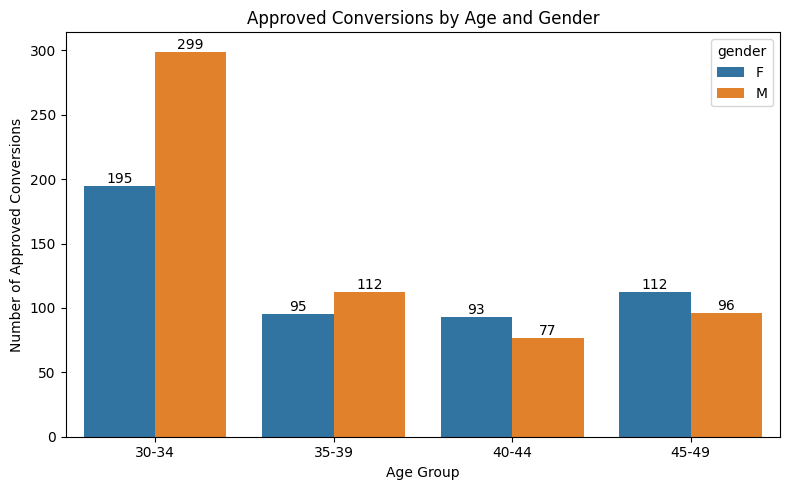

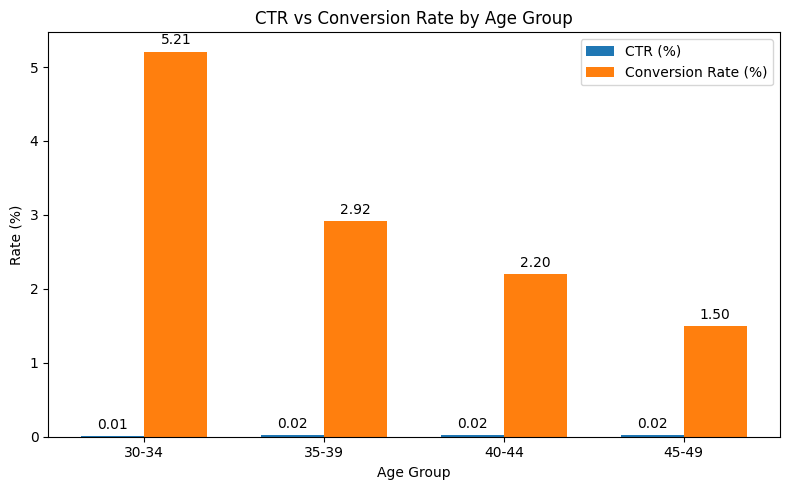

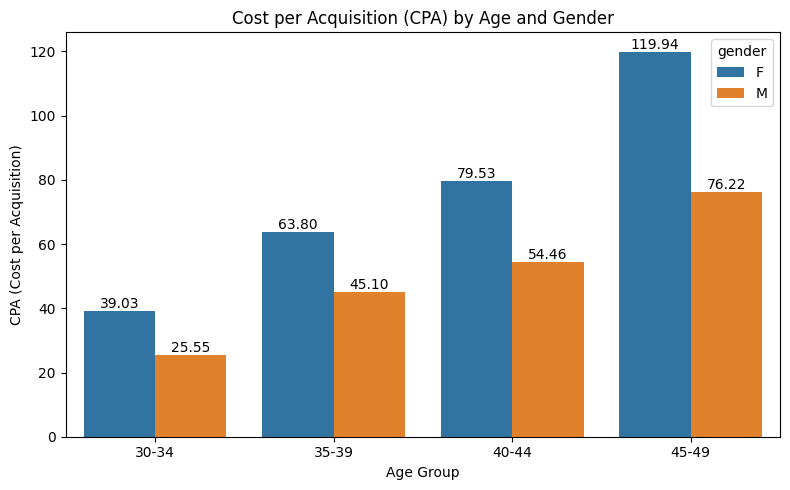

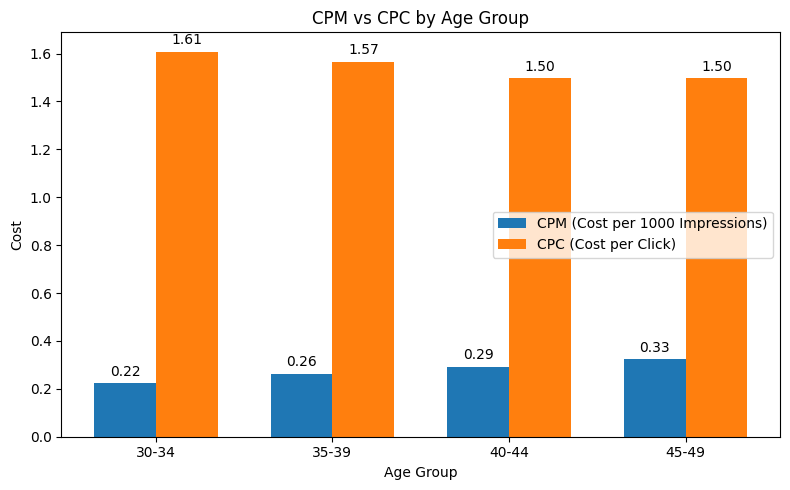

In [18]:
# --- Visualisations ---

# Re-aggregate by age and gender to ensure all necessary columns are present
agg_demo = df.groupby(['age', 'gender']).agg(
    impressions=('Impressions', 'sum'),
    clicks=('Clicks', 'sum'),
    conversions=('conversions', 'sum'), # Use 'conversions'
    spent=('Spent', 'sum')
).reset_index()

# Re-aggregate by age only to ensure all necessary columns are present
agg_age = df.groupby('age').agg(
    impressions=('Impressions', 'sum'),
    clicks=('Clicks', 'sum'),
    conversions=('conversions', 'sum'), # Use 'conversions'
    spent=('Spent', 'sum')
).reset_index()

# Calculate CPC for agg_age
agg_age['CPC'] = np.where(agg_age['clicks'] > 0,
                     agg_age['spent'] / agg_age['clicks'],
                     np.nan)

# Calculate ConversionRate for agg_age (used in second plot)
agg_age['ConversionRate'] = np.where(
    agg_age['clicks'] > 0,
    agg_age['conversions'] / agg_age['clicks'] * 100,
    0
)

# Calculate CPM for agg_age (used in fourth plot)
agg_age['CPM'] = agg_age['spent'] / agg_age['impressions'] * 1000

# Calculate CPA for agg_age (not plotted in this cell but good to have)
agg_age['CPA'] = np.where(
    agg_age['conversions'] > 0,
    agg_age['spent'] / agg_age['conversions'],
    np.nan
)

# 1. Conversions by age and gender
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=agg_demo, x='age', y='conversions', hue='gender')
plt.title('Approved Conversions by Age and Gender')
plt.ylabel('Number of Approved Conversions')
plt.xlabel('Age Group')
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge')
plt.tight_layout()
plt.show()

# 2. CTR vs Conversion Rate by age group
plt.figure(figsize=(8, 5))
width = 0.35
x = np.arange(len(agg_age['age']))
# Ensure CTR is calculated on agg_age as well if needed for this plot
agg_age['CTR'] = agg_age['clicks'] / agg_age['impressions'] * 100
bars_ctr = plt.bar(x - width/2, agg_age['CTR'], width, label='CTR (%)')
bars_cvr = plt.bar(x + width/2, agg_age['ConversionRate'], width, label='Conversion Rate (%)')
plt.xticks(x, agg_age['age'])
plt.ylabel('Rate (%)')
plt.xlabel('Age Group')
plt.title('CTR vs Conversion Rate by Age Group')
plt.legend()
plt.bar_label(bars_ctr, labels=[f"{v:.2f}" for v in agg_age['CTR']], padding=3)
plt.bar_label(bars_cvr, labels=[f"{v:.2f}" for v in agg_age['ConversionRate']], padding=3)
plt.tight_layout()
plt.show()

# 3. CPA by age and gender
plt.figure(figsize=(8, 5))
# Calculate CPA for agg_demo
agg_demo['CPA'] = np.where(agg_demo['conversions'] > 0,
                           agg_demo['spent'] / agg_demo['conversions'], np.nan)
ax2 = sns.barplot(data=agg_demo, x='age', y='CPA', hue='gender')
plt.title('Cost per Acquisition (CPA) by Age and Gender')
plt.ylabel('CPA (Cost per Acquisition)')
plt.xlabel('Age Group')
for container in ax2.containers:
    ax2.bar_label(container, fmt='%.2f', label_type='edge')
plt.tight_layout()
plt.show()

# 4. CPM vs CPC by age group
plt.figure(figsize=(8, 5))
bars_cpm = plt.bar(x - width/2, agg_age['CPM'], width, label='CPM (Cost per 1000 Impressions)')
bars_cpc = plt.bar(x + width/2, agg_age['CPC'], width, label='CPC (Cost per Click)')
plt.xticks(x, agg_age['age'])
plt.ylabel('Cost')
plt.xlabel('Age Group')
plt.title('CPM vs CPC by Age Group')
plt.legend()
plt.bar_label(bars_cpm, labels=[f"{v:.2f}" for v in agg_age['CPM']], padding=3)
plt.bar_label(bars_cpc, labels=[f"{v:.2f}" for v in agg_age['CPC']], padding=3)
plt.tight_layout()
plt.show()

ON INDIVIDUAL LEVEL

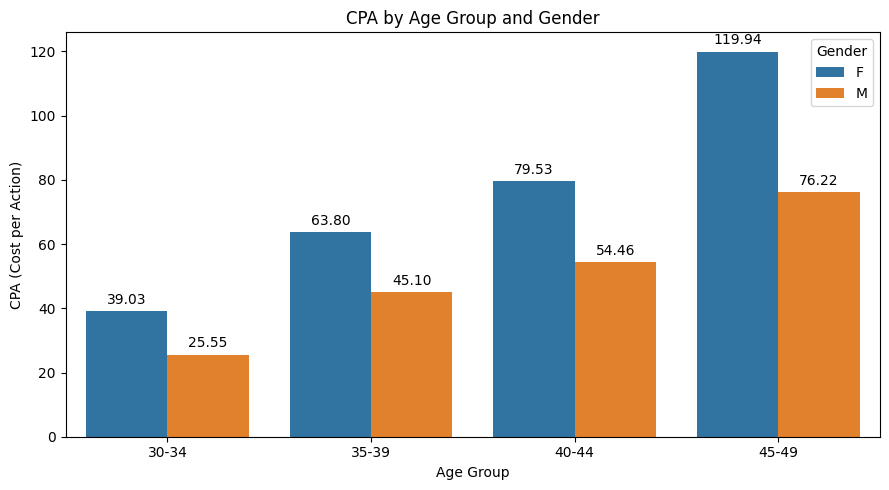

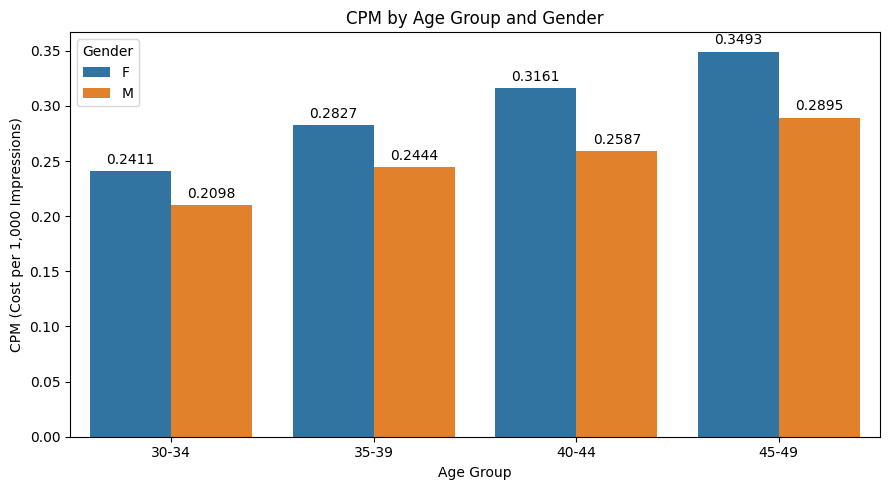

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Keep age in natural order
age_order = ['30-34', '35-39', '40-44', '45-49']
grouped_view['age'] = pd.Categorical(grouped_view['age'], categories=age_order, ordered=True)

# --- CPA: bar chart with hue=gender ---
plt.figure(figsize=(9, 5))
ax = sns.barplot(
    data=grouped_view,
    x='age', y='CPA', hue='gender',
    order=age_order, hue_order=['F','M'],
    errorbar=None
)
ax.set_title('CPA by Age Group and Gender')
ax.set_xlabel('Age Group')
ax.set_ylabel('CPA (Cost per Action)')
ax.legend(title='Gender')

# add value labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

plt.tight_layout()
plt.show()

# --- CPM: bar chart with hue=gender ---
plt.figure(figsize=(9, 5))
ax = sns.barplot(
    data=grouped_view,
    x='age', y='CPM', hue='gender',
    order=age_order, hue_order=['F','M'],
    errorbar=None
)
ax.set_title('CPM by Age Group and Gender')
ax.set_xlabel('Age Group')
ax.set_ylabel('CPM (Cost per 1,000 Impressions)')
ax.legend(title='Gender')

# add value labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.4f', padding=3)

plt.tight_layout()
plt.show()


INDIVIDUAL LEVEL

On individual level, Female with age group 45-49 has the highest CPA and the highest CPM

In [20]:
import pandas as pd
import numpy as np

# --- ensure keys are clean ---
df['age'] = df['age'].astype(str).str.strip()
df['gender'] = df['gender'].astype(str).str.strip().str.upper()

# If interest isn't numeric in your CSV, coerce it so sum works
df['interest'] = pd.to_numeric(df['interest'], errors='coerce')

# --- aggregate by GENDER + AGE ---
agg_demo = (df.groupby(['gender', 'age'], as_index=False)
              .agg(impressions=('Impressions', 'sum'),
                   conversions=('conversions', 'sum'),   # used for CPA only
                   spent=('Spent', 'sum'),
                   ad_id=('ad_id', 'first'),
                   # keep one representative interest for the flat view (optional)
                   interest_rep=('interest', lambda x: x.mode().iat[0] if not x.mode().empty else x.iloc[0]),
                   # sum of interest for the pivot (this fixes your issue)
                   interest_sum=('interest', 'sum')))

# metrics
agg_demo['CPA'] = np.where(agg_demo['conversions'] > 0,
                           agg_demo['spent'] / agg_demo['conversions'], np.nan)
agg_demo['CPM'] = np.where(agg_demo['impressions'] > 0,
                           agg_demo['spent'] / agg_demo['impressions'] * 1000, np.nan)

# Flat view (keeps representative interest; conversions hidden)
grouped_view = (agg_demo.rename(columns={'interest_rep':'interest'})
                [['gender','age','ad_id','interest','CPA','CPM']]
                .sort_values(['age','gender'])
                .reset_index(drop=True))

# --- pivots: conversions & interest SUM ---
conversion_pivot = agg_demo.pivot(index='age', columns='gender', values='conversions')
interest_pivot   = agg_demo.pivot(index='age', columns='gender', values='interest_sum')

print("\nConversions pivot (rows: age, cols: gender):")
print(conversion_pivot.to_string(
    index=True,
    formatters={col: (lambda v: f"{int(v)}" if pd.notna(v) else "NA") for col in conversion_pivot.columns}
))

print("\nInterest SUM pivot (rows: age, cols: gender):")
print(interest_pivot.to_string(
    index=True,
    formatters={col: (lambda v: f"{int(v)}" if pd.notna(v) else "NA") for col in interest_pivot.columns}
))


Conversions pivot (rows: age, cols: gender):
gender   F   M
age           
30-34  195 299
35-39   95 112
40-44   93  77
45-49  112  96

Interest SUM pivot (rows: age, cols: gender):
gender    F    M
age             
30-34  6280 6850
35-39  3971 4429
40-44  3852 3378
45-49  4678 4014


The conversion (approved) and the Interestv is the highest for age group 30-34 for both genders. Altrhough overall, Males in tend to havea better approved conversion and interest in this age group
